In [35]:
import os
import ast
import csv
import glob
import json
import ineqpy
import numpy as np
import pandas as pd
import seaborn as sns
import scipy.stats as stats
import plotly.express as px
import plotly.graph_objects as go
import matplotlib.pyplot as plt

from scipy import stats
from pathlib import Path
from collections import Counter
from collections import defaultdict

In [130]:
path_data = Path("../data")
path_meta = Path("../meta")
path_rq1 = path_meta / 'rq1'
path_rq2 = path_meta / 'rq2'

font_size = 15

platform_abbreviation_mapping = {
    'gh': 'GitHub',
    'hf': 'HuggingFace',
    'pwc': 'PapersWithCode',
    'iw': 'independent website',
}

platform_abbreviation_mapping_inverse = {v: k for k, v in platform_abbreviation_mapping.items()}

leaderboard_organization_strategies_mapping = {
    'Evaluation Configuration': ['Evaluation Dataset', 'Evaluation Metric', 'Evaluator'],
    'Leaderboard Layout': ['Aggregated Result'],
    'Leaderboard Release': ['Leaderboard Version', 'Leaderboard Launch Date'],
    'Model Capability': ['Benchmark', 'Service Load', 'Supported Functionality', 'Supported Language', 'Supported Modality', 'Task'],
    'Model Information': ['Model Accessibility', 'Model Size', 'Model Type'],
    'Prompt Engineering': ['#Prompt Example', 'Output Length', 'Prompt Design', 'Prompt Length','Tokenizer']
}

submission_synonyms = {
    'Instant Message': ['WeChat']
}

macro_display_format_mapping = {
    'Table': ['Rankable Table', 'Regular Table', 'Table Screenshot'],
    'Figure': ['Bar Chart', 'Box Plot', 'Heatmap', 'Line Chart', 'Pie Chart', 'Radar Chart', 'Rankable Bar Chart', 'Scatter Plot'],
}
macro_display_format_mapping_inverse = {v: k for k, values in macro_display_format_mapping.items() for v in values}

organizer_synonyms = {
    'Alibaba Group': ['Alibaba Group DAMO Academy', 'Aliyun'],
    'Amazon': ['Amazon Alexa AI Lab', 'Amazon AWS AI Lab'],
    'Google': ['Google DeepMind', 'Google Brain'],
    'Huawei': ["Huawei Noah's Ark Lab"],
    'Max Planck Institutes': ['Max Planck Institute for Informatics'],
    'Meta': [
        'Meta FAIR',
        'Meta GenAI'
    ],
    'Microsoft': ['Microsoft Research Asia'],
    'Tencent': [
        'Tencent AI Lab',
        'Tencent ARC Lab',
        'Tencent Youtu Lab'
    ],
    'Toyota Technological Institute': ['Toyota Technological Institute Chicago'],
    'University of California': [
        'University of California Berkeley',
        'University of California Los Angeles',
        'University of California Santa Barbara',
        'University of California San Diego',
        'University of California Irvine',
    ],
    'University of North Carolina': ['University of North Carolina Chapel Hill'],
    'University of Illinois': ['University of Illinois Chicago', 'University of Illinois Urbana Champaign'],
    'University of Massachusetts': ['University of Massachusetts Amherst'],
    'University of Maryland': ['University of Maryland College Park'],
    'University of Tennessee': ['University of Tennessee Knoxville'],
    'University of Texas': ['University of Texas Austin'],
    'University of Wisconsin': ['University of Wisconsin Madison'],
    '': ['MIT-IBM Watson AI Lab'],
    'International Business Machines': ['MIT-IBM Watson AI Lab'],
}

metrics_synonyms = {
    'accuracy': [
        'acc',
        'accuarcy',
        'qa accuracy'
    ],
    'average': [
        'avg',
        '平均'
    ],
    'average accuracy': [
        'avg. accuracy'
    ],
    'average score': ['平均分'],
    'bleu': ['bleu score'],
    'bleu-1': [
        'narrativeqa bleu-1',
        'socialiqa bleu-1',
        'mcscript bleu-1',
        'cosmosqa bleu-1'
    ],
    'bleu-4': ['bleu4'],
    'bertscore': ['bert score'],
    'code': ['代码'],
    'elo rating': [
        'chatbot arena elo',
        'elo'
    ],
    'exact match': ['em', 'exact match accuracy'],
    'lerc': [
        'cosmosqa lerc',
        'mcscript lerc',
        'socialiqa lerc',
        'narrativeqa lerc'
    ],
    'link': ['url'],
    'mean rank': [
        'text-to-video mean rank',
        'video-to-text mean rank'
    ],
    'median rank': [
        'text-to-video median rank',
        'video-to-text median rank',
        'text-to-videomedian rank',
        'text-to-video medianr'
    ],
    'meteor': [
        'cosmosqa meteor',
        'narrativeqa meteor',
        'socialiqa meteor',
        'mcscript meteor'
    ],
    'neg mean rank': [
        'i->t neg mean rank',
        't->i neg mean rank'
    ],
    'organization': [
        '发布机构',
        '机构',
        'orgaisation',
    ],
    'others': ['其他'],
    'overall': ['xiezhi overall'],
    'overall score': [
        '总分',
        '总体分数'
    ],
    'pass@1': [
        'interview pass@1',
        'competition pass@1',
        'introductory pass@1'
    ],
    'pass@5': [
        'interview pass@5',
        'introductory pass@5',
        'competition pass@5'
    ],
    'pass@1000': [
        'interview pass@1000',
        'competition pass@1000',
        'introductory pass@1000'
    ],
    'pass@any': [
        'introductory pass@any',
        'competition pass@any',
        'interview pass@any'
    ],
    '#parameters':  [
        '#params',
        '# params',
        '#size',
        '参数量',
        'model size',
        'model size/b',
        'number of params',
        'param',
        'parameters',
        'params',
        'size'
    ],
    'perplexity': ['ppl'],
    'precision@1': ['i->t p@1'],
    'precision@20': ['p@20'],
    'recall@1': [
        'r@1',
        'text-to-videor@1',
        'video-to-text r@1',
        'text-to-video r@1',
        'text-to-image r@1',
        'image-to-text r@1'
    ],
    'recall@5': [
        'text-to-image r@5',
        'video-to-text r@5',
        'image-to-text r@5',
        'text-to-video r@5',
        'r@5',
    ],
    'recall@10': [
        'recall@10 on 1 rounds',
        'recall@10 on 2 rounds',
        'recall@10 on 3 rounds',
        'r@10',
        'video-to-text r@10',
        'text-to-image r@10',
        'text-to-video r@10',
        'image-to-text r@10'
    ],
    'recall@50': [
        'text-to-video r@50',
        'video-to-text r@50',
    ],
    'score': ['分数'],
    'submission date': ['提交时间'],
    'top-1 accuracy': ['top 1 accuracy'],
    'top-5 accuracy': ['top 5 accuracy'],
    'type': ['model type'],
    'win rate': ['胜率'],
    'word error rate': ['wer']
}

model_naming_convention = {
    'Model Publisher (first line)': [
        'Provider Leaderboard'
    ],
    'Repository Username': [
        'EQ-Bench (v2)',
        'HHEM Leaderboard',
        'Big Code Models Leaderboard',
        'Colossal-AI',
        'DecodingTrust',
        'LLMPerf Leaderboard',
        'LLM-Perf Leaderboard',
        'Open LLM Leaderboard',
        'Open Ko-LLM Leaderboard',
        'ScandEval'
    ],
}

dashed_model_leaderboards = ['MMCU', 'SuperCLUE-Math6']

metrics_synonyms_inverse = {}
for key, values in metrics_synonyms.items():
    for value in values:
        metrics_synonyms_inverse[value] = key
        
submission_synonyms_inverse = {}
for key, values in submission_synonyms.items():
    for value in values:
        submission_synonyms_inverse[value] = key

organizer_synonyms_inverse = {}
for key, values in organizer_synonyms.items():
    for value in values:
        organizer_synonyms_inverse[value] = key

leaderboard_organization_strategies_mapping_inverse = {}
for key, values in leaderboard_organization_strategies_mapping.items():
    for value in values:
        leaderboard_organization_strategies_mapping_inverse[value] = key

model_naming_convention_count = {
    k: len(v) for k, v in model_naming_convention.items()}

def convert_csv_to_dict(file_path):
    """
    Convert a CSV file of leaderboards and metrics to a dictionary.

    :param file_path: Path to the CSV file
    :return: Dictionary with leaderboards as keys and list of metrics as values
    """
    leaderboard_data = {}

    # Read the CSV file
    with open(file_path, mode='r') as file:
        csv_reader = csv.reader(file)
        next(csv_reader)  # Skip the header row

        # Iterate through each row
        for row in csv_reader:
            if row:  # Check if row is not empty
                key = row[0]  # The first element is the key
                # List comprehension to get non-empty values
                values = [value for value in row[1:] if value]
                leaderboard_data[key] = values

    return leaderboard_data


def string_to_list(text, platform=False):
    if pd.isna(text):
        return []
    elif platform:
        return [platform_abbreviation_mapping[platform] for platform in text.split(',')]
    else:
        return text.split(',')


def string_to_dict(s, platform=False):
    # Check if the input is np.nan
    if pd.isna(s):
        return {}
    # Split the string into key-value pairs
    pairs = s.split(',')
    result_dict = {}
    for pair in pairs:
        # Split each pair by ':' to separate keys and values
        key, value = pair.split(':')
        # Split the value by '+' to get the list of items
        value_list = value.split('+')
        # Assign the list to the key in the dictionary
        if platform:
            result_dict[platform_abbreviation_mapping[key]] = value_list
        else:
            result_dict[key] = value_list
    return result_dict


def filter_platform(groups, filters):
    groups_processed = []
    for group in groups:
        group_processed = []
        for platform in group:
            if platform_abbreviation_mapping_inverse[platform] not in filters:
                group_processed.append(platform)
        if group_processed:
            groups_processed.append(group_processed)
    return groups_processed


# Function to format each value based on its own decimal places
def format_individual_value(x):
    if isinstance(x, float):
        # Use string formatting to maintain original decimal places
        return "{:f}".format(x).rstrip('0').rstrip('.')
    return x


def print_empty_folders(root_dir):
    for dirpath, dirnames, filenames in os.walk(root_dir):
        # Check if both lists of subdirectories and filenames are empty
        if not filenames:
            print(f"Empty folder: {dirpath}")


def file_rename(name, channel):
    name = name.lower()
    name = name.replace(' - ', '-')
    name = name.replace(' ', '_')
    name = name.replace(".csv", ".json")
    if channel:
        name = f'{channel}-{name}'
    return name


def process_model(model_str):
    if '](' in model_str:
        model_str = model_str.split('](')[0][1:]
        
    # Substrings to be removed
    substrings_to_remove = ['🥇', '🥈', '🥉', '🗒️', '📄', '🌍', '✨', '💙', '💚', '†', '*']
    
    # Remove each unwanted substring
    for substring in substrings_to_remove:
        model_str = model_str.replace(substring, '')
        
    return model_str.strip()
    

def list_directories(folder_path):
    # List all subdirectories within the folder
    directories = [os.path.join(folder_path, d) for d in os.listdir(
        folder_path) if os.path.isdir(os.path.join(folder_path, d))]
    return directories


def organizer_synonyms_mapping(organizers, leaderboard):
    organizers_processed = set()
    for organizer in organizers:
        if organizer in organizer_synonyms_inverse:
            organizers_processed.add(organizer_synonyms_inverse[organizer])
        elif 'Independent Contributor' == organizer:
            organizers_processed.add(leaderboard)
        else:
            organizers_processed.add(organizer)
    return list(organizers_processed)


def check_element_in_list2(element, list2):
    for list1 in list2:
        if element in list1:
            return True
    return False

In [4]:
df = pd.read_csv(path_rq1 / 'Leaderboard.csv')

for index, row in df.iterrows():
    folder_path = os.path.join(path_data, row['Leaderboard name'])
    os.makedirs(folder_path, exist_ok=True)

print_empty_folders(str(path_data))

In [51]:
directory = path_data / "LAiW Leaderboard"
channel = ''
drop_columns = []

for file in glob.glob(str(directory / "*.csv")):
    df = pd.read_csv(file)
    filename = file.split('/')[-1]
    filename = file_rename(filename, channel)
    df.drop(columns=drop_columns, inplace=True)
    df.to_json(directory / filename, orient="records", indent=4)
    os.remove(file)


In [38]:
# Aligning Diverse Leaderboards for Standardized Analysis 
for directory in os.listdir(path_data):
    dash = directory in dashed_model_leaderboards
    subdirectory_path = os.path.join(path_data, directory)
    for file in glob.glob(os.path.join(subdirectory_path, "*.json")):
        try:
            df = pd.read_json(file)
            df['Model'] = df['Model'].str.replace('_', '-') if dash else df['Model'].apply(process_model)
            df.to_json(file, orient='records', indent=4)
        except:
            print(file)


In [39]:
total_records = 0
total_publishers = 0
total_splits = 0
total_benchmarks = 0
# total_template_scenarios = 0
# total_template_publishers = 0
# total_nontemplate_scenarios = 0
# total_nontemplate_publishers = 0

for folder in list_directories(path_data):
    total_benchmarks += 1
    prefixes = []
    
    for root, dirs, files in os.walk(folder):
        for file in files:
            if file.endswith('.json'):
                file_path = os.path.join(root, file)
                df = pd.read_json(file_path)
                total_records += len(df)
                total_splits += 1
                for prefix in platform_abbreviation_mapping.keys():
                    if file.startswith(prefix):
                        prefixes.append(prefix)
                        break
                    
    total_publishers += len(set(prefixes))
    # template_publishers = [p for p in prefixes if p not in platform_nontemplate]
    # nontemplate_publishers = [p for p in prefixes if p in platform_nontemplate]
    # total_template_publishers += len(set(template_publishers))
    # total_nontemplate_publishers += len(set(nontemplate_publishers))
    # total_template_scenarios += len(template_publishers)
    # total_nontemplate_scenarios += len(nontemplate_publishers)

print(f"Total number of evaluation records: {total_records}")
print(f"Total number of leaderboards (benchmark): {total_benchmarks}")
print(f"Total number of leaderboards (publisher): {total_publishers}")
print(f"Total number of leaderboards (split): {total_splits}")
# print(f"Total number of leaderboards (publisher) (template): {total_template_publishers}")
# print(f"Total number of leaderboards (scenario) (template): {total_template_scenarios}")
# print(f"Total number of leaderboards (publisher) (non-pwc): {total_nontemplate_publishers}")
# print(f"Total number of leaderboards (scenario) (non-pwc): {total_nontemplate_scenarios}")

benchmark_mapping = convert_csv_to_dict(path_rq1 / 'Benchmark.csv')
leaderboard_benchmarks = set()
for key in benchmark_mapping.keys():
    benchmarks = [benchmark if benchmark == 'ARC [Abstraction and Reasoning Corpus]' else benchmark.split(' (')[0] for benchmark in benchmark_mapping[key]]
    leaderboard_benchmarks = leaderboard_benchmarks.union(set(benchmarks))
print('Total number of benchmarks:', len(leaderboard_benchmarks))


Total number of evaluation records: 55569
Total number of leaderboards (benchmark): 305
Total number of leaderboards (publisher): 335
Total number of leaderboards (split): 2408
Total number of benchmarks: 739


In [118]:
df_leaderboard = pd.read_csv(path_rq1 / 'Leaderboard.csv')
df_leaderboard['Display format (non-pwc)'] = df_leaderboard['Display format (non-pwc)'].apply(lambda x: string_to_dict(x, platform=True))
df_leaderboard['Feedback manners (iw)'] = df_leaderboard['Feedback manners (iw)'].apply(string_to_list)
df_leaderboard['Host platforms'] = df_leaderboard['Host platforms'].apply(lambda x: string_to_list(x, platform=True))
df_leaderboard['Host platforms with leaderboard downloading functionality (non-pwc)'] = df_leaderboard['Host platforms with leaderboard downloading functionality (non-pwc)'].apply(lambda x: string_to_list(x, platform=True))
df_leaderboard['Host platforms with model linkage (non-pwc)'] = df_leaderboard['Host platforms with model linkage (non-pwc)'].apply(lambda x: string_to_list(x, platform=True))
df_leaderboard['Publishing organizations (non-pwc)'] = df_leaderboard['Publishing organizations (non-pwc)'].apply(string_to_list)
df_leaderboard['Publishing venues'] = df_leaderboard['Publishing venues'].apply(string_to_list)
df_leaderboard['Structuring strategies (non-pwc)'] = df_leaderboard['Structuring strategies (non-pwc)'].apply(string_to_list)
df_leaderboard['Submission artifacts (non-pwc)'] = df_leaderboard['Submission artifacts (non-pwc)'].apply(string_to_list)
df_leaderboard['Submission manners (non-pwc)'] = df_leaderboard['Submission manners (non-pwc)'].apply(string_to_list)
df_leaderboard['Supported languages'] = df_leaderboard['Supported languages'].apply(string_to_list)
df_leaderboard['Supported modalities'] = df_leaderboard['Supported modalities'].apply(string_to_list)

df_leaderboard['Benchmarks'] = [[] for _ in range(len(df_leaderboard))]
df_leaderboard['Evaluated models'] = [[] for _ in range(len(df_leaderboard))]
df_leaderboard['Evaluation metrics (pwc)'] = [[] for _ in range(len(df_leaderboard))]

benchmark_mapping = convert_csv_to_dict(path_rq1 / 'Benchmark.csv')
for key, values in benchmark_mapping.items():
    benchmark_mapping[key] = list(set([value.split(' (')[0] for value in values]))

for index, row in df_leaderboard.iterrows():
    if row['Leaderboard name'] == 'MTEB':
        benchmarks = benchmark_mapping['MTEB'] + benchmark_mapping['CMTEB']
    elif row['Leaderboard name'] in benchmark_mapping:
        benchmarks = benchmark_mapping[row['Leaderboard name']]
    else:
        benchmarks = [row['Leaderboard name'].split(' (')[0]]
        
    df_leaderboard.at[index, 'Benchmarks'] = benchmarks
    df_leaderboard.at[index, '#Benchmark'] = len(benchmarks)

    display_formats = set()
    feedback_manners = set()
    publishing_organizers = organizer_synonyms_mapping(row['Publishing organizations (non-pwc)'], row['Leaderboard name'])
    submission_manners = set()
    structuring_strategies = set(row['Structuring strategies (non-pwc)'])
    
    if check_element_in_list2('PapersWithCode', row['Host platforms']):
        display_formats.union({'Rankable Table', 'Scatter Plot'})
        publishing_organizers.append('PapersWithCode')
        structuring_strategies.add('Task')
        
    for key, values in row['Display format (non-pwc)'].items():
        display_formats = display_formats.union(set(values))
        
    df_leaderboard.at[index, '#Display format'] = len(display_formats)
    df_leaderboard.at[index, '#Host platform'] = len(row['Host platforms'])
    df_leaderboard.at[index, '#Publishing organization'] = len(publishing_organizers)
    df_leaderboard.at[index, '#Supported Language'] = len(row['Supported languages'])
    df_leaderboard.at[index, '#Supported Modality'] = len(row['Supported modalities'])
    df_leaderboard.at[index, '#Structuring strategy'] = len(structuring_strategies)

    split = 0
    submission = 0
    model_names = set()
    template_metrics = set()
    
    for file in os.listdir(path_data / row['Leaderboard name']):
        host_platform = platform_abbreviation_mapping[file.split('.')[0].split('-')[0]]
        if host_platform not in row['Host platforms']:
            continue
        
        file_path = path_data / row['Leaderboard name'] / file
        df = pd.read_json(file_path)
        submission += len(df)
        
        if directory in model_naming_convention['Repository Username']:
            df['Model'] = df['Model'].apply(lambda x: x.split('/')[-1])
            
        df['Model'] = df['Model'].apply(lambda x: x.split('\n')[0].split('(')[0].strip())
        model_names = model_names.union(set(df['Model']))
        
        file_name = file.split('/')[-1]
        if file_name.startswith('pwc'):
            keys = set()
            for item in df['metrics']:
                for key in item.keys():
                    key_processed = key.split('(')[0].lower().strip()
                    if key_processed in metrics_synonyms_inverse:
                        keys.add(metrics_synonyms_inverse[key_processed])
                    else:
                        keys.add(key_processed)
            template_metrics = template_metrics.union(keys)
        else:
            split += 1
    
    df_leaderboard.at[index, '#Leaderboard split (non-pwc)'] = split
    df_leaderboard.at[index, '#Evaluation record'] = submission
    df_leaderboard.at[index, '#Evaluated model'] = len(model_names)
    df_leaderboard.at[index, 'Evaluated models'] = list(model_names)
    df_leaderboard.at[index, 'Evaluation metrics (pwc)'] = list(template_metrics)
        
df_leaderboard['Weight'] = 1
df_leaderboard.to_csv(path_rq1 / 'Leaderboard_processed.csv', index=False)


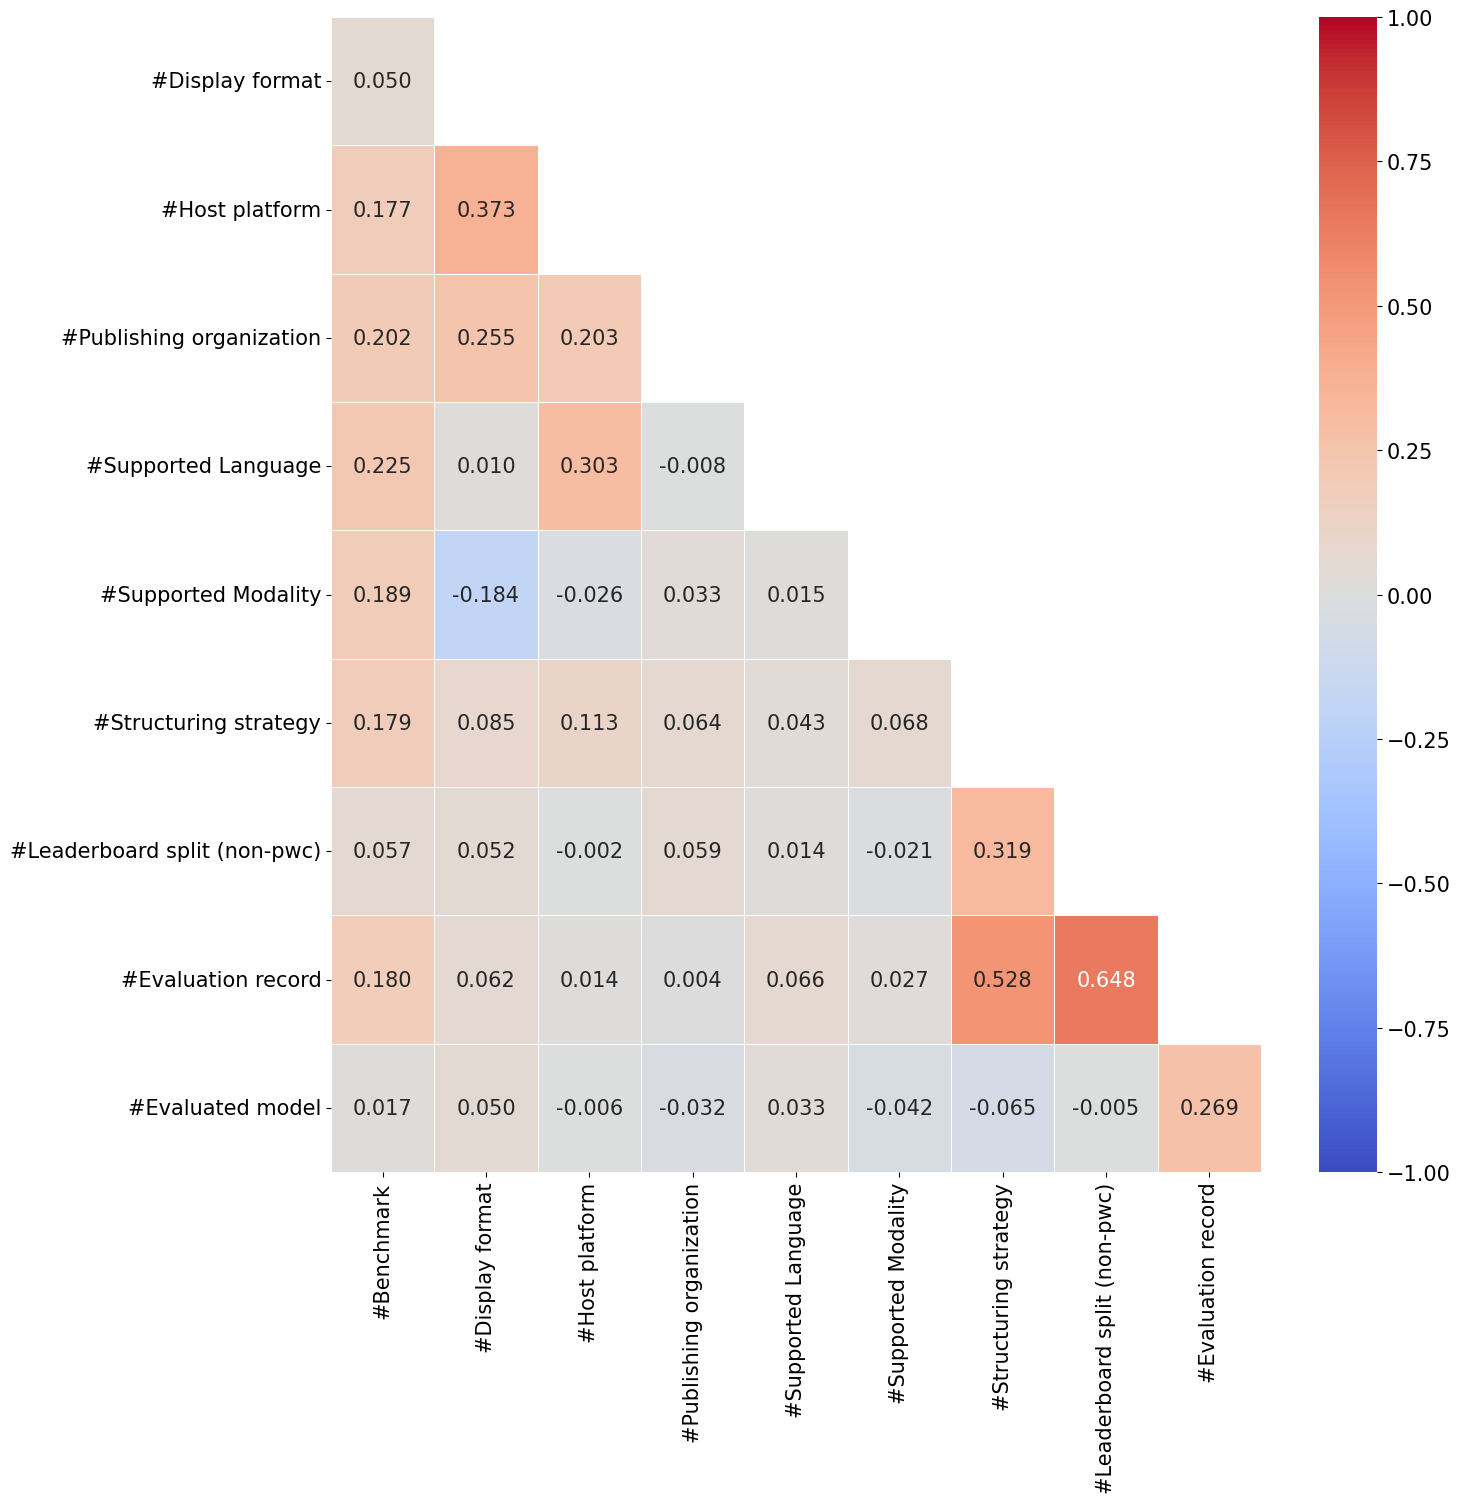

In [85]:
df = pd.read_csv(path_rq1 / 'Leaderboard_processed.csv')
numeric_df = df.select_dtypes(include=['float64', 'int64'])
numeric_df = numeric_df.drop(columns=['Weight'])
corr_matrix = numeric_df.corr()

# Drop the first row
corr_matrix_dropped_row = corr_matrix.drop(corr_matrix.index[0])

# Drop the last column
corr_matrix_dropped = corr_matrix_dropped_row.drop(corr_matrix_dropped_row.columns[-1], axis=1)

# Generate a mask for the upper triangle, including the diagonal
mask = np.triu(np.ones_like(corr_matrix_dropped, dtype=bool), 1)

# Generate a heatmap for the correlation matrix with the mask
plt.figure(figsize=(15,15))
ax = sns.heatmap(corr_matrix_dropped, annot=True, cmap='coolwarm', fmt=".3f", linewidths=.5, mask=mask, vmin=-1, vmax=1, annot_kws={"size": font_size})
# Enlarge axis font size
ax.tick_params(axis='both', which='major', labelsize=font_size)
# Adjust color bar (color scale) font size
cbar = ax.collections[0].colorbar
cbar.ax.tick_params(labelsize=font_size)  # Adjusts the tick labels' font size

# plt.title('Correlation Matrix Heatmap for Leaderboard Attributes')
plt.savefig(path_rq1 / 'leaderboard attribute heatmap.pdf', format='pdf')
plt.show()


In [72]:
df = pd.read_csv(path_rq1 / 'Leaderboard_processed.csv')
df = df[df['Structuring strategies (non-pwc)'].map(len) > 0]
print(f"{len(df[df['#Empty leaderboards (non-pwc)'].notna()])} multi-scenario leaderboards (excluding PapersWithCode) have missing scenarios, accounting for {round(len(df[df['#Empty leaderboards (non-pwc)'].notna()])/len(df)*100,2)}% of the total.")
df['#Empty leaderboards (non-pwc)'].value_counts().reset_index()

4 multi-scenario leaderboards (excluding PapersWithCode) have missing scenarios, accounting for 1.21% of the total.


,#Empty leaderboards (non-pwc),count
0,2,2
1,?,2


Rankable Table is the most prevalent display format adopted by 97 leaderboards.


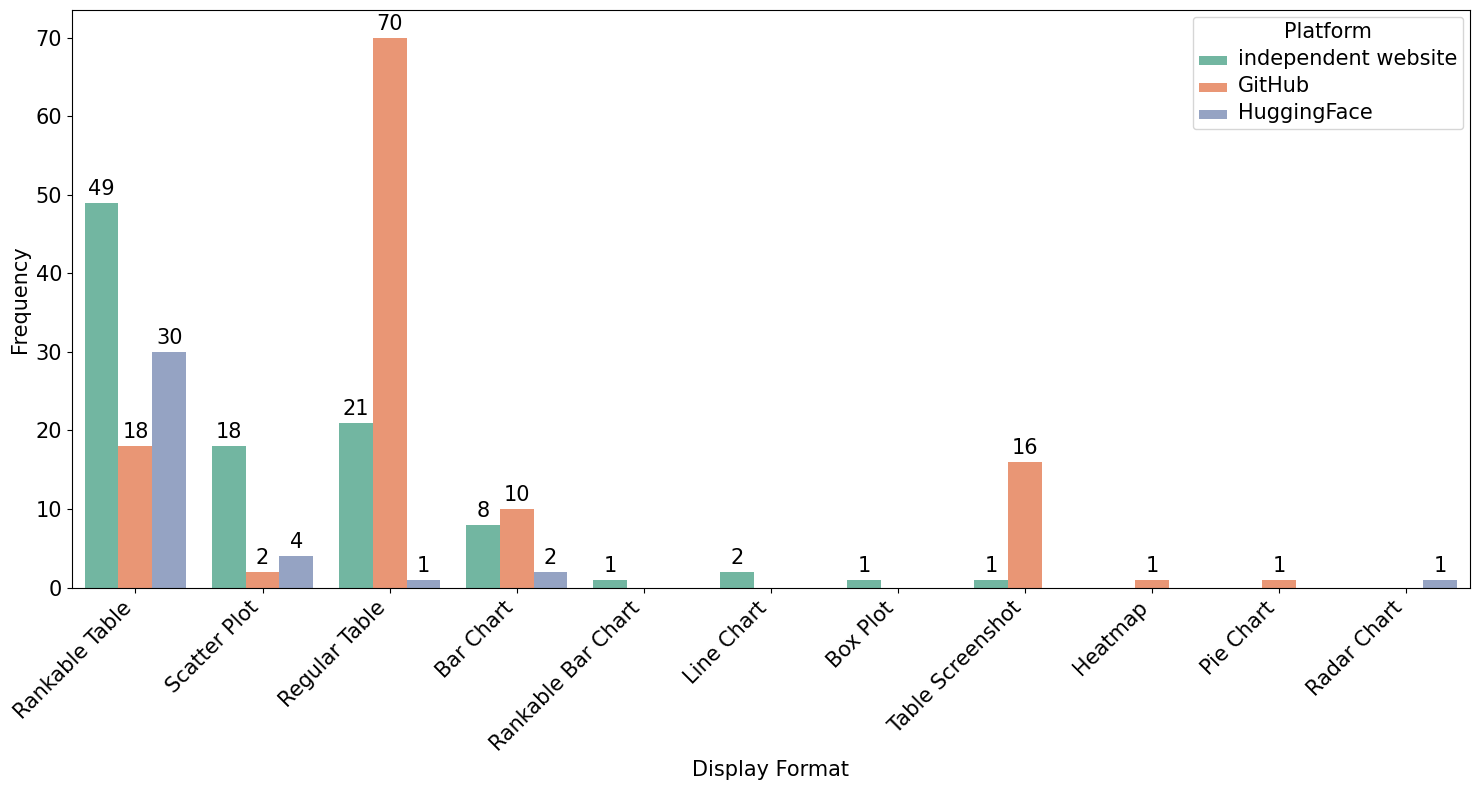

<Figure size 640x480 with 0 Axes>

In [212]:
df = pd.read_csv(path_rq1 / 'Leaderboard_processed.csv')
df['Display format (non-pwc)'] = df['Display format (non-pwc)'].apply(ast.literal_eval)

format_counts = defaultdict(lambda: defaultdict(int))
for index, row in df.iterrows():
    # Loop through each platform and its formats in the dictionary
    for platform, formats in row['Display format (non-pwc)'].items():
        for format_type in formats:
            # Increment the count for the format type under its respective platform
            format_counts[platform][format_type] += 1
            
flattened_data = []
for platform, formats in format_counts.items():
    for format_type, count in formats.items():
        flattened_data.append({'Platform': platform, 'Display Format': format_type, 'Frequency': count})
        
format_counts_df = pd.DataFrame(flattened_data)
format_counts_df_only = format_counts_df.groupby('Display Format').sum().reset_index()
format_counts_df_only['Weight'] = 1

statistics = {
    'Property': 'Distribution of Leaderboard across Display Formats',
    'Mean': round(np.mean(format_counts_df_only['Frequency']), 2),
    'Median': np.median(format_counts_df_only['Frequency']),
    'Mode': stats.mode(format_counts_df_only['Frequency'])[0],
    'Standard Deviation': round(np.std(format_counts_df_only['Frequency']), 2),
    'Gini Coefficient': round(ineqpy.inequality.gini(data=format_counts_df_only, income='Frequency', weights='Weight'), 3),
}
df_statistics = pd.DataFrame()
df_statistics = pd.concat([df_statistics, pd.DataFrame([statistics])], ignore_index=True)
df_statistics.to_csv(path_rq1 / 'leaderboard_statistics.csv', index=False)

df_top = format_counts_df_only.sort_values(by='Frequency', ascending=False).head(10)
print(f"{df_top['Display Format'].iloc[0]} is the most prevalent display format adopted by {df_top['Frequency'].iloc[0]} leaderboards.")

# Plotting
plt.figure(figsize=(15, 8))  # Adjust figure size as needed
ax = sns.barplot(
    x='Display Format', 
    y='Frequency', 
    hue='Platform',  # This separates the bars within each group by platform
    data=format_counts_df, 
    palette='Set2',  # Choose a palette that makes the bars distinct
    dodge=True  # Adjust this to control the gap between bars of different platforms within the same group
)

# Setting the title and labels with enlarged fonts
ax.set_xlabel('Display Format', fontsize=font_size)  # Enlarge x-axis label
ax.set_ylabel('Frequency', fontsize=font_size)  # Enlarge y-axis label
plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for better readability

# Enlarge axis ticks font size
ax.tick_params(axis='both', which='major', labelsize=font_size)

# Adding annotations on top of each bar
for p in ax.patches:
    if p.get_height():
        ax.annotate(format(p.get_height(), '.0f'),  # Format the number displayed
                (p.get_x() + p.get_width() / 2., p.get_height()),  # Position
                ha = 'center', va = 'center', 
                xytext = (0, 10),  # Distance from the top of the bar
                textcoords = 'offset points', fontsize=font_size)

# Adjust the legend
leg = ax.legend(title='Platform')
leg.set_title('Platform', prop={'size':font_size})  # Set the title font size
for text in leg.get_texts():  # Set the font size for each legend text
    text.set_fontsize(font_size)
plt.tight_layout()  # Adjust the plot to ensure everything fits without overlapping
plt.show()

# Save the plot to a PDF file
plt.savefig(path_rq1 / 'display format distribution.pdf', bbox_inches='tight')

In [ ]:
df = pd.read_csv(path_rq1 / 'Leaderboard_processed.csv')

statistics = {
    'Property': 'Distribution of Display Format across Leaderboards',
    'Mean': round(np.mean(df['#Display Format']), 2),
    'Median': np.median(df['#Display Format']),
    'Mode': stats.mode(df['#Display Format'])[0],
    'Standard Deviation': round(np.std(df['#Display Format']), 2),
}
df_statistics = pd.read_csv(path_rq1 / 'leaderboard_statistics.csv')
df_statistics = pd.concat([df_statistics, pd.DataFrame([statistics])], ignore_index=True)
df_statistics.to_csv(path_rq1 / 'leaderboard_statistics.csv', index=False)

df_top = df.drop_duplicates(subset=['Leaderboard name']).sort_values(by='#Supported Modality', ascending=False).head(10)
print(f"{df_top['Leaderboard name'].iloc[0]} supports the highest number of modality up to {int(df_top['#Supported Modality'].iloc[0])}.")

fig = go.Figure(go.Bar(
        x=df_top['#Supported Modality'],  # Values for the bar lengths
        y=df_top['Leaderboard name'],  # Categories for each bar
        orientation='h',  # Sets the bars to be horizontal
        text=df_top['#Supported Modality'],  # Adds the values as text on each bar
        textposition='auto'  # Automatically positions the text on the bars
))
fig.update_layout(
        xaxis_title='Publishing organizations Number',
        yaxis_title='Leaderboard Name',
        yaxis_autorange='reversed'  # This line makes the bars go top-down
)
# Update the layout for a tighter look
fig.update_layout(
    autosize=True,
    margin=dict(
        l=10,  # Left margin
        r=10,  # Right margin
        b=10,  # Bottom margin
        t=10,  # Top margin
        pad=4  # Padding between the plot and the margin
    )
)
fig.show()


format_counts = defaultdict(lambda: defaultdict(int))
for index, row in df.iterrows():
    # Loop through each platform and its formats in the dictionary
    for platform, formats in row['Display format (non-pwc)'].items():
        for format_type in formats:
            # Increment the count for the format type under its respective platform
            format_counts[platform][format_type] += 1
            
flattened_data = []
for platform, formats in format_counts.items():
    for format_type, count in formats.items():
        flattened_data.append({'Platform': platform, 'Display Format': format_type, 'Frequency': count})
        
format_counts_df = pd.DataFrame(flattened_data)
format_counts_df_only = format_counts_df.groupby('Display Format').sum().reset_index()
format_counts_df_only['Weight'] = 1

statistics = {
    'Property': 'Distribution of Leaderboard across Display Formats',
    'Mean': round(np.mean(format_counts_df_only['Frequency']), 2),
    'Median': np.median(format_counts_df_only['Frequency']),
    'Mode': stats.mode(format_counts_df_only['Frequency'])[0],
    'Standard Deviation': round(np.std(format_counts_df_only['Frequency']), 2),
    'Gini Coefficient': round(ineqpy.inequality.gini(data=format_counts_df_only, income='Frequency', weights='Weight'), 3),
}
df_statistics = pd.DataFrame()
df_statistics = pd.concat([df_statistics, pd.DataFrame([statistics])], ignore_index=True)
df_statistics.to_csv(path_rq1 / 'leaderboard_statistics.csv', index=False)

df_top = format_counts_df_only.sort_values(by='Frequency', ascending=False).head(10)
print(f"{df_top['Display Format'].iloc[0]} is the most prevalent display format adopted by {df_top['Frequency'].iloc[0]} leaderboards.")

# Plotting
plt.figure(figsize=(15, 8))  # Adjust figure size as needed
ax = sns.barplot(
    x='Display Format', 
    y='Frequency', 
    hue='Platform',  # This separates the bars within each group by platform
    data=format_counts_df, 
    palette='Set2',  # Choose a palette that makes the bars distinct
    dodge=True  # Adjust this to control the gap between bars of different platforms within the same group
)

# Setting the title and labels with enlarged fonts
ax.set_xlabel('Display Format', fontsize=font_size)  # Enlarge x-axis label
ax.set_ylabel('Frequency', fontsize=font_size)  # Enlarge y-axis label
plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for better readability

# Enlarge axis ticks font size
ax.tick_params(axis='both', which='major', labelsize=font_size)

# Adding annotations on top of each bar
for p in ax.patches:
    if p.get_height():
        ax.annotate(format(p.get_height(), '.0f'),  # Format the number displayed
                (p.get_x() + p.get_width() / 2., p.get_height()),  # Position
                ha = 'center', va = 'center', 
                xytext = (0, 10),  # Distance from the top of the bar
                textcoords = 'offset points', fontsize=font_size)

# Adjust the legend
leg = ax.legend(title='Platform')
leg.set_title('Platform', prop={'size':font_size})  # Set the title font size
for text in leg.get_texts():  # Set the font size for each legend text
    text.set_fontsize(font_size)
plt.tight_layout()  # Adjust the plot to ensure everything fits without overlapping
plt.show()

# Save the plot to a PDF file
plt.savefig(path_rq1 / 'display format distribution.pdf', bbox_inches='tight')

In [209]:
df = pd.read_csv(path_rq1 / 'Leaderboard_processed.csv')
df['Host platforms'] = df['Host platforms'].apply(ast.literal_eval)
print(f"Only {len(df[df['Host platforms'].map(len) > 1])} publishers host their leaderboards on multiple platforms, accounting for {round(len(df[df['Host platforms'].map(len) > 1])/len(df),4)*100}% of the total.")

platform_counts = df.explode('Host platforms')['Host platforms'].value_counts().reset_index()
print(f"{platform_counts['Host platforms'].iloc[0]} is the most popular host platform, accounting for {round(platform_counts['count'].iloc[0]/len(df)*100,2)}% leaderboards.")
platform_counts['Weight'] = 1

statistics = {
    'Property': 'Distribution of Leaderboard across Host Platforms',
    'Mean': round(np.mean(platform_counts['count']), 2),
    'Median': np.median(platform_counts['count']),
    'Mode': stats.mode(platform_counts['count'])[0],
    'Standard Deviation': round(np.std(platform_counts['count']), 2),
    'Gini Coefficient': round(ineqpy.inequality.gini(data=platform_counts, income='count', weights='Weight'), 3),
}
df_statistics = pd.read_csv(path_rq1 / 'leaderboard_statistics.csv')
df_statistics = pd.concat([df_statistics, pd.DataFrame([statistics])], ignore_index=True)
df_statistics.to_csv(path_rq1 / 'leaderboard_statistics.csv', index=False)

fig = px.bar(
    x=platform_counts['Host platforms'],
    y=platform_counts['count'],
    text_auto=True,
    labels={'x': 'Host platforms', 'y': 'Number of Leaderboards'},
)
# Update the layout for a tighter look
fig.update_layout(
    autosize=True,
    margin=dict(
        l=10,  # Left margin
        r=10,  # Right margin
        b=10,  # Bottom margin
        t=10,  # Top margin
        pad=4  # Padding between the plot and the margin
    )
)
fig.write_image(path_rq1 / 'host platform distribution.pdf')
fig.show()

Only 32 publishers host their leaderboards on multiple platforms, accounting for 9.67% of the total.
PapersWithCode is the most popular host platform, accounting for 49.85% leaderboards.


In [ ]:
df = pd.read_csv(path_rq1 / 'Leaderboard_processed.csv')
df['Publishing organizations (non-pwc)'] = df['Publishing organizations (non-pwc)'].apply(ast.literal_eval)

for index, row in df.iterrows():
    organizers = organizer_synonyms_mapping(row['Publishing organizations (non-pwc)'], row['Leaderboard name'])
    if 'PapersWithCode' in row['Host platforms']:
        organizers.append('PapersWithCode')
    df.at[index, 'Publishing organizations (non-pwc)'] = organizers
    
organizer_mapping = df.set_index('Leaderboard name')['Publishing organizations (non-pwc)'].to_dict()
org_item_count = Counter(org for orgs in organizer_mapping.values() for org in orgs)
df = pd.DataFrame(list(org_item_count.items()), columns=['Publishing organizations (non-pwc)', '#Leaderboard'])
df['Weight'] = 1

mean = np.mean(df['#Leaderboard'])
median = np.median(df['#Leaderboard'])
mode = stats.mode(df['#Leaderboard'])[0]  # mode() returns a ModeResult object, hence the indexing
standard_deviation = np.std(df['#Leaderboard'])

print(f"Mean: {mean}")
print(f"Median: {median}")
print(f"Mode: {mode}")
print(f"Standard Deviation: {standard_deviation}")

# Calculate the Gini coefficient
gini_coefficient = ineqpy.inequality.gini(data=df, income='#Leaderboard', weights='Weight')
print("Gini Coefficient:", gini_coefficient)
df_top = df.sort_values(by='#Leaderboard', ascending=False).head(10)
print(f"{df_top['Publishing organizations (non-pwc)'].iloc[0]} is the most productive publisher among the {len(df)} publishers, accounting for {round(df_top['#Leaderboard'].iloc[0]/df['#Leaderboard'].sum()*100,2)}% ({df_top['#Leaderboard'].iloc[0]} out of {df['#Leaderboard'].sum()}) leaderboards.")

fig = go.Figure(go.Bar(
        x=df_top['#Leaderboard'],  # Values for the bar lengths
        y=df_top['Publishing organizations (non-pwc)'],  # Categories for each bar
        orientation='h',  # Sets the bars to be horizontal
        text=df_top['#Leaderboard'],  # Adds the values as text on each bar
        textposition='auto'  # Automatically positions the text on the bars
))
fig.update_layout(
        title=f'Number of Leaderboards across Publishing organizations (Top 10)',
        xaxis_title='Leaderboard Number',
        yaxis_title='Publisher Name',
        yaxis_autorange='reversed'  # This line makes the bars go top-down
)
fig.write_image(path_rq1 / 'publisher distribution (top-10).pdf')
fig.show()


In [211]:
df = pd.read_csv(path_rq1 / 'Leaderboard_processed.csv')

statistics = {
    'Property': 'Distribution of Modality across Leaderboards',
    'Mean': round(np.mean(df['#Supported Modality']), 2),
    'Median': np.median(df['#Supported Modality']),
    'Mode': stats.mode(df['#Supported Modality'])[0],
    'Standard Deviation': round(np.std(df['#Supported Modality']), 2),
}
df_statistics = pd.read_csv(path_rq1 / 'leaderboard_statistics.csv')
df_statistics = pd.concat([df_statistics, pd.DataFrame([statistics])], ignore_index=True)
df_statistics.to_csv(path_rq1 / 'leaderboard_statistics.csv', index=False)

df_top = df.drop_duplicates(subset=['Leaderboard name']).sort_values(by='#Supported Modality', ascending=False).head(10)
print(f"{df_top['Leaderboard name'].iloc[0]} supports the highest number of modality up to {int(df_top['#Supported Modality'].iloc[0])}.")

fig = go.Figure(go.Bar(
        x=df_top['#Supported Modality'],  # Values for the bar lengths
        y=df_top['Leaderboard name'],  # Categories for each bar
        orientation='h',  # Sets the bars to be horizontal
        text=df_top['#Supported Modality'],  # Adds the values as text on each bar
        textposition='auto'  # Automatically positions the text on the bars
))
fig.update_layout(
        xaxis_title='Publishing organizations Number',
        yaxis_title='Leaderboard Name',
        yaxis_autorange='reversed'  # This line makes the bars go top-down
)
# Update the layout for a tighter look
fig.update_layout(
    autosize=True,
    margin=dict(
        l=10,  # Left margin
        r=10,  # Right margin
        b=10,  # Bottom margin
        t=10,  # Top margin
        pad=4  # Padding between the plot and the margin
    )
)
fig.show()


FlagEval supports the highest number of modality up to 4.


In [19]:
df = pd.read_csv(path_rq1 / 'Leaderboard_processed.csv')
df['Supported languages'] = df['Supported languages'].apply(ast.literal_eval)
print(f"{len(df[df['Supported languages'].apply(lambda x: 'English' in x)])} leaderboards focus on English tasks, comprising {round(len(df[df['Supported languages'].apply(lambda x: 'English' in x)])/len(df),4)*100}% of the total.")
df = df.explode('Supported languages')['Supported languages'].value_counts().reset_index()
df['Weight'] = 1

mean = np.mean(df['count'])
median = np.median(df['count'])
mode = stats.mode(df['count'])[0]  # mode() returns a ModeResult object, hence the indexing
standard_deviation = np.std(df['count'])

print(f"Mean: {mean}")
print(f"Median: {median}")
print(f"Mode: {mode}")
print(f"Standard Deviation: {standard_deviation}")

# Calculate the Gini coefficient
gini_coefficient = ineqpy.inequality.gini(data=df, income='count', weights='Weight')
print("Gini Coefficient:", gini_coefficient)

df = df[df['count'] > 3]
fig = px.bar(
    x=df['Supported languages'],
    y=df['count'],
    text_auto=True,
    labels={'x': 'Supported languages', 'y': 'Count of Leaderboards'},
    title='Number of Leaderboard across Supported Languages'
)
# Update the layout for a tighter look
fig.update_layout(
    autosize=True,
    margin=dict(
        l=10,  # Left margin
        r=10,  # Right margin
        b=10,  # Bottom margin
        t=10,  # Top margin
        pad=4  # Padding between the plot and the margin
    )
)
fig.show()


240 leaderboards focus on English tasks, comprising 88.56% of the total.
Mean: 3.9145299145299144
Median: 1.0
Mode: 1
Standard Deviation: 22.30004125923615
Gini Coefficient: 0.7096446318325539


In [16]:
df = pd.read_csv(path_rq1 / 'Leaderboard_processed.csv')

mean = np.mean(df['#Supported Language'])
median = np.median(df['#Supported Language'])
mode = stats.mode(df['#Supported Language'])[0]  # mode() returns a ModeResult object, hence the indexing
standard_deviation = np.std(df['#Supported Language'])

print(f"Mean: {mean}")
print(f"Median: {median}")
print(f"Mode: {mode}")
print(f"Standard Deviation: {standard_deviation}")

# Calculate the Gini coefficient
gini_coefficient = ineqpy.inequality.gini(data=df, income='#Supported Language', weights='Weight')
print("Gini Coefficient:", gini_coefficient)
df_top = df.sort_values(by='#Supported Language', ascending=False).head(10)
print(f"{df_top['Leaderboard name'].iloc[0]} is the leaderboard involving the most number of publishing organization up to {df_top['#Supported Language'].iloc[0]}.")

fig = go.Figure(go.Bar(
        x=df_top['#Supported Language'],  # Values for the bar lengths
        y=df_top['Leaderboard name'],  # Categories for each bar
        orientation='h',  # Sets the bars to be horizontal
        text=df_top['#Supported Language'],  # Adds the values as text on each bar
        textposition='auto'  # Automatically positions the text on the bars
))
fig.update_layout(
        title=f'Number of Supported Languages across Leaderboards (Top 10)',
        xaxis_title='Publishing organizations Number',
        yaxis_title='Leaderboard Name',
        yaxis_autorange='reversed'  # This line makes the bars go top-down
)
# fig.write_image(path_rq1 / 'publishing organization distribution (top-10).pdf')
fig.show()


Mean: 1.6900369003690037
Median: 1.0
Mode: 1
Standard Deviation: 7.013945807603327
Gini Coefficient: 0.4024421801714336
MTEB is the leaderboard involving the most number of publishing organization up to 112.


In [20]:
df = pd.read_csv(path_rq1 / 'Leaderboard_processed.csv')
df = df[df['#Publishing organization'] > 0]

mean = np.mean(df['#Publishing organization'])
median = np.median(df['#Publishing organization'])
mode = stats.mode(df['#Publishing organization'])[0]  # mode() returns a ModeResult object, hence the indexing
standard_deviation = np.std(df['#Publishing organization'])

print(f"Mean: {mean}")
print(f"Median: {median}")
print(f"Mode: {mode}")
print(f"Standard Deviation: {standard_deviation}")

# Calculate the Gini coefficient
gini_coefficient = ineqpy.inequality.gini(data=df, income='#Publishing organization', weights='Weight')
print("Gini Coefficient:", gini_coefficient)
df_top = df.sort_values(by='#Publishing organization', ascending=False).head(10)
print(f"{df_top['Leaderboard name'].iloc[0]} is the leaderboard involving the most number of publishing organization up to {df_top['#Publishing organization'].iloc[0]}.")

fig = go.Figure(go.Bar(
        x=df_top['#Publishing organization'],  # Values for the bar lengths
        y=df_top['Leaderboard name'],  # Categories for each bar
        orientation='h',  # Sets the bars to be horizontal
        text=df_top['#Publishing organization'],  # Adds the values as text on each bar
        textposition='auto'  # Automatically positions the text on the bars
))
fig.update_layout(
        title=f'Number of Publishing organizations across Leaderboards (Top 10)',
        xaxis_title='Publishing organizations Number',
        yaxis_title='Leaderboard Name',
        yaxis_autorange='reversed'  # This line makes the bars go top-down
)
# fig.write_image(path_rq1 / 'publishing organization distribution (top-10).pdf')
fig.show()


Mean: 2.9794520547945207
Median: 2.0
Mode: 1.0
Standard Deviation: 3.3484185146231527
Gini Coefficient: 0.4124137931034498
TrustLLM is the leaderboard involving the most number of publishing organization up to 36.0.


In [86]:
df = pd.read_csv(path_rq1 / 'Leaderboard_processed.csv')
df['Host platforms'] = df['Host platforms'].apply(ast.literal_eval)
df['Host platforms'] = df['Host platforms'].apply(filter_platform, filters=['pwc'])
df = df[df['Host platforms'].map(len) > 0]

df['Host platforms with model linkage (non-pwc)'] = df['Host platforms with model linkage (non-pwc)'].apply(ast.literal_eval)
print(f"{len(df[df['Host platforms with model linkage (non-pwc)'].map(len) > 0])} non-template leaderboards have accessible linkage to the evaluated models in their leaderboards, accounting for {round(len(df[df['Host platforms with model linkage (non-pwc)'].map(len) > 0])/len(df),4)*100}% of the total.")
df_provenance = df[df['Host platforms with model linkage (non-pwc)'].map(len) > 0]
df_provenance = df_provenance.explode('Host platforms with model linkage (non-pwc)')
df_provenance['Host platforms with model linkage (non-pwc)'] = df_provenance['Host platforms with model linkage (non-pwc)'].map(platform_abbreviation_mapping)
df_provenance = df_provenance['Host platforms with model linkage (non-pwc)'].value_counts().reset_index()

fig = px.bar(
    x=df_provenance['Host platforms with model linkage (non-pwc)'],
    y=df_provenance['count'],
    text_auto=True,
    labels={'x': 'Host platforms', 'y': 'Count of leaderboards with model provenance linkage'},
    title='Number of Leaderboards with Model Provenance Linkage across Platforms (non-pwc)'
)
# fig.write_image(path_rq1 / 'platform distribution.pdf')
fig.show()

total_data = 0
# total_paper = 0
# total_code = 0
total_provenance = 0

# average_paper_rate = []
# average_code_rate = []
average_provenance_rate = []

for root, dirs, files in os.walk(path_data):
    for file in files:
        if file.startswith('pwc') and file.endswith(".json"):
            with open(os.path.join(root, file), 'r') as file:
                json_data = json.load(file)
                total_data += len(json_data)
                json_external = [external for external in json_data if type(external['external_source_url']) == str]
                total_provenance += len(json_external)
                if not len(json_external):
                    json_internal = [paper for paper in json_data if type(paper['paper']['id']) == int]
                    total_provenance += len(json_internal)
                    average_provenance_rate.append(len(json_internal)/len(json_data))
                    # json_paper = [paper for paper in json_data if type(paper['paper']['id']) == int]
                    # total_paper += len(json_paper)
                    # average_paper_rate.append(len(json_paper)/len(json_data)*100)
                    # json_code = [code for code in json_paper if code['paper']['code'] == True]
                    # if len(json_code):
                    #     total_code += len(json_code)
                    #     average_code_rate.append(len(json_code)/len(json_paper)*100)

print(f'Total provenance rate across all leaderboard: {round(total_provenance/total_data, 4)*100}%, namely {total_provenance} out of {total_data} evaluation records.')
print(f'Average provenance rate across crowdsourced leaderboard: {round(sum(average_provenance_rate)/len(average_provenance_rate), 4)*100}%')


55 non-template leaderboards have accessible linkage to the evaluated models in their leaderboards, accounting for 39.86% of the total.


Total provenance rate across all leaderboard: 97.97%, namely 6628 out of 6765 evaluation records.
Average provenance rate across crowdsourced leaderboard: 98.95%


In [23]:
df = pd.read_csv(path_rq1 / 'Leaderboard_processed.csv')
df['Host platforms'] = df['Host platforms'].apply(ast.literal_eval)
df['Host platforms'] = df['Host platforms'].apply(filter_platform, filters=['pwc'])
df = df[df['Host platforms'].map(len) > 0]
        
df['Submission manners (non-pwc)'] = df['Submission manners (non-pwc)'].apply(ast.literal_eval)
df['Submission artifacts (non-pwc)'] = df['Submission artifacts (non-pwc)'].apply(ast.literal_eval)
print(f"Of the {len(df)} non-template leaderboards collected, {len(df[df['Submission manners (non-pwc)'].map(len) > 0])} (accounting for {round(len(df[df['Submission manners (non-pwc)'].map(len) > 0])/len(df)*100,2)}%) do not explicitly encourage the submission of evaluation records.")

df = df[df['Submission manners (non-pwc)'].map(len) > 0]
df_manner = df.explode('Submission manners (non-pwc)')
df_manner['Submission manners (non-pwc)'] = df_manner['Submission manners (non-pwc)'].apply(lambda x: submission_synonyms_inverse[x] if x in submission_synonyms_inverse else x)
df_manner = df_manner['Submission manners (non-pwc)'].value_counts().reset_index()
print(f"{df_manner['Submission manners (non-pwc)'].iloc[0]} is the most popular Submission manner for non-template leaderboards, accounting for {round(df_manner['count'].iloc[0]/len(df)*100,2)}% of the total.")

df_manner['Weight'] = 1
# Calculate the Gini coefficient
gini_coefficient = ineqpy.inequality.gini(data=df_manner, income='count', weights='Weight')
print("Gini Coefficient:", gini_coefficient)

fig = px.bar(
    x=df_manner['Submission manners (non-pwc)'], 
    y=df_manner['count'],
    text_auto=True,
    labels={'x': 'Submission manner', 'y': 'Number of Leaderboards'},
    title='Number of Submission Manner across Non-template-based Leaderboards'
)
fig.write_image(path_rq1 / 'submission manner distribution.pdf')
fig.show()

df_artifact = df.explode('Submission artifacts (non-pwc)')
df_artifact = df_artifact['Submission artifacts (non-pwc)'].value_counts().reset_index()
print(f"{df_artifact['Submission artifacts (non-pwc)'].iloc[0]} is the most popular submission manner for non-template leaderboards, accounting for {round(df_artifact['count'].iloc[0]/len(df)*100,2)}% of the total.")

df_artifact['Weight'] = 1
# Calculate the Gini coefficient
gini_coefficient = ineqpy.inequality.gini(data=df_artifact, income='count', weights='Weight')
print("Gini Coefficient:", gini_coefficient)

fig = px.bar(
    x=df_artifact['Submission artifacts (non-pwc)'],
    y=df_artifact['count'],
    text_auto=True,
    labels={'x': 'Submission artifact', 'y': 'Number of Leaderboards'},
    title='Number of Submission Artifact across Non-template-based Leaderboards'
)
# fig.write_image(path_rq1 / 'submission artifact distribution.pdf')
fig.show()

Of the 144 non-template leaderboards collected, 72 (accounting for 50.0%) do not explicitly encourage the submission of evaluation records.
Submission Portal is the most popular Submission manner for non-template leaderboards, accounting for 40.28% of the total.
Gini Coefficient: 0.5310077519379846


Evaluation Results is the most popular submission manner for non-template leaderboards, accounting for 73.61% of the total.
Gini Coefficient: 0.5793650793650793


In [32]:
df = pd.read_csv(path_rq1 / 'Leaderboard_processed.csv')
df['Host platforms'] = df['Host platforms'].apply(ast.literal_eval)
df['Host platforms'] = df['Host platforms'].apply(filter_platform, filters=['pwc'])
for index, row in df.iterrows():
    if (len(row['Host platforms']) == 1) and (row['Host platforms'][0] == ['independent website']):
        continue
    df.drop(index, inplace=True)
    
df['Feedback manners (iw)'] = df['Feedback manners (iw)'].apply(ast.literal_eval)
print(f"Among leaderboards exclusively hosted on independent websites (up to {len(df)}), {round(len(df[df['Feedback manners (iw)'].map(len) > 0])/len(df)*100,2)}% of them provide feedback channels, with only {len(df[df['Feedback manners (iw)'].map(len) == 0])} exception.")
df_provenance = df[df['Feedback manners (iw)'].map(len) > 0]
df_provenance = df_provenance.explode('Feedback manners (iw)')
df_provenance = df_provenance['Feedback manners (iw)'].value_counts().reset_index()

fig = px.bar(
    x=df_provenance['Feedback manners (iw)'],
    y=df_provenance['count'],
    text_auto=True,
    labels={'x': 'Host platforms', 'y': 'Count of leaderboards with model provenance linkage'},
    title='Distribution Feedback Channels across Leaderboards Hosted on Independent Websites'
)
# fig.write_image(path_rq1 / 'platform distribution.pdf')
fig.show()

Among leaderboards exclusively hosted on independent websites (up to 27), 96.3% of them provide feedback channels, with only 1 exception.


In [57]:
df = pd.read_csv(path_rq1 / 'Leaderboard_processed.csv')
df['Publishing venues'] = df['Publishing venues'].apply(ast.literal_eval)
print(f"{len(df[df['Publishing venues'].map(len) > 0])} leaderboards are associated with specific publications, including articles, preprints, and reports, accounting for {round(len(df[df['Publishing venues'].map(len) > 0])/len(df),4)*100}% of the total.")
df = df[df['Publishing venues'].map(len) > 0]
print(f"{len(df[df['Publishing venues'].apply(lambda x: 'Preprint' in x)])} of these publication have been accepted in a specific workshop, conference and journal, accounting for {round(len(df[df['Publishing venues'].apply(lambda x: 'Preprint' in x)])/len(df),4)*100}% of the total.")
df = df[~df['Publishing venues'].apply(lambda x: 'Preprint' in x)]
organizer_mapping = df.set_index('Leaderboard name')['Publishing venues'].to_dict()
org_item_count = Counter(org for orgs in organizer_mapping.values() for org in orgs)
df = pd.DataFrame(list(org_item_count.items()), columns=['Publishing venues', '#Leaderboard'])
df['Weight'] = 1

mean = np.mean(df['#Leaderboard'])
median = np.median(df['#Leaderboard'])
mode = stats.mode(df['#Leaderboard'])[0]  # mode() returns a ModeResult object, hence the indexing
standard_deviation = np.std(df['#Leaderboard'])

print(f"Mean: {mean}")
print(f"Median: {median}")
print(f"Mode: {mode}")
print(f"Standard Deviation: {standard_deviation}")

# Calculate the Gini coefficient
gini_coefficient = ineqpy.inequality.gini(data=df, income='#Leaderboard', weights='Weight')
print("Gini Coefficient:", gini_coefficient)
df_top = df.sort_values(by='#Leaderboard', ascending=False).head(10)
print(f"{df_top['Publishing venues'].iloc[0]} emerges as the most represented conference, accounting for {round(df_top['#Leaderboard'].iloc[0]/df['#Leaderboard'].sum(),4)*100}% of the total, with {df_top['#Leaderboard'].iloc[0]} out of {df['#Leaderboard'].sum()} articles originating from this conference.")

fig = go.Figure(go.Bar(
        x=df_top['#Leaderboard'],  # Values for the bar lengths
        y=df_top['Publishing venues'],  # Categories for each bar
        orientation='h',  # Sets the bars to be horizontal
        text=df_top['#Leaderboard'],  # Adds the values as text on each bar
        textposition='auto'  # Automatically positions the text on the bars
))
fig.update_layout(
        title=f'Number of Accepted Articles across Academic Publishing Venues (Top 10)',
        xaxis_title='Article Number',
        yaxis_title='Publication Name',
        yaxis_autorange='reversed'  # This line makes the bars go top-down
)
fig.write_image(path_rq1 / 'publication venue distribution (top-10).pdf')
fig.show()


238 benchmark-based leaderboards are associated with specific publications, including papers, preprints, and reports, accounting for 87.82% of the total.
96 of these publication have been accepted in a specific workshop, conference and journal, accounting for 40.339999999999996% of the total.
Mean: 4.0
Median: 1.0
Mode: 1
Standard Deviation: 5.259911279353167
Gini Coefficient: 0.5968253968253971
EMNLP emerges as the most represented conference, accounting for 15.97% of the total, with 23 out of 144 papers originating from this conference.


In [64]:
df = pd.read_csv(path_rq1 / 'Leaderboard_processed.csv')
df['Supported modalities'] = df['Supported modalities'].apply(ast.literal_eval)
modality_counts = df.explode('Supported modalities')['Supported modalities'].value_counts().reset_index()
modality_counts['Weight'] = 1

# Calculate the Gini coefficient
gini_coefficient = ineqpy.inequality.gini(data=modality_counts, income='count', weights='Weight')
print("Gini Coefficient:", gini_coefficient)

fig = px.bar(
    x=modality_counts['Supported modalities'],
    y=modality_counts['count'],
    text_auto=True,
    labels={'x': 'Supported modalities', 'y': 'Count of Leaderboards'},
    title='Number of Leaderboard across Modalities'
)
# fig.write_image(path_rq1 / 'task modality distribution.pdf')
fig.show()


Gini Coefficient: 0.7690288713910762


In [10]:
df = pd.read_csv(path_rq1 / 'Leaderboard_processed.csv')
df = df[df["#Split"] > 0]
print(f'{len(df[df["#Split"] > 1])} leaderboards (excluding PapersWithCode) have multiple scenarios, accounting for {round(len(df[df["#Split"] > 1])/len(df)*100,2)}% of the total.')

mean = np.mean(df['#Split'])
median = np.median(df['#Split'])
mode = stats.mode(df['#Split'])[0]  # mode() returns a ModeResult object, hence the indexing
standard_deviation = np.std(df['#Split'])

print(f"Mean: {mean}")
print(f"Median: {median}")
print(f"Mode: {mode}")
print(f"Standard Deviation: {standard_deviation}")

scenario_counts = df.explode('#Split')['#Split'].value_counts().reset_index()
scenario_counts['Weight'] = 1

# Calculate the Gini coefficient
gini_coefficient = ineqpy.inequality.gini(data=scenario_counts, income='count', weights='Weight')
print("Gini Coefficient:", gini_coefficient)

df_top = df.sort_values(by='#Split', ascending=False).head(10)
print(f"{df_top['Leaderboard name'].iloc[0]} holds the most number of scenario up to {df_top['#Split'].iloc[0]}.")

fig = go.Figure(go.Bar(
        x=df_top['#Split'],  # Values for the bar lengths
        y=df_top['Leaderboard name'],  # Categories for each bar
        orientation='h',  # Sets the bars to be horizontal
        text=df_top['#Split'],  # Adds the values as text on each bar
        textposition='auto'  # Automatically positions the text on the bars
))
fig.update_layout(
        title=f'Number of Splits in Leaderboards (Top 10)',
        xaxis_title='Scenario Number',
        yaxis_title='Leaderboard Name',
        yaxis_autorange='reversed'  # This line makes the bars go top-down
)
fig.write_image(path_rq1 / 'scenario distribution (top-10).pdf')
fig.show()

# scenario_counts = scenario_counts[scenario_counts['#Split'] < 10]
# fig = px.bar(
#     x=scenario_counts['#Split'],
#     y=scenario_counts['count'],
#     text_auto=True,
#     labels={'x': '#Split', 'y': 'Count of Leaderboards'},
#     title='Number of Scenarios across Leaderboards'
# )
# # fig.write_image(path_rq1 / 'scenario distribution.pdf')
# fig.show()

70 leaderboards (excluding PapersWithCode) have multiple scenarios, accounting for 43.75% of the total.
Mean: 10.8125
Median: 1.0
Mode: 1
Standard Deviation: 73.56937096203828
Gini Coefficient: 0.7921875000000002
LMExamQA holds the most number of scenario up to 884.


In [10]:
df = pd.read_csv(path_rq1 / 'Leaderboard_processed.csv')
df['Structuring strategies (non-pwc)'] = df['Structuring strategies (non-pwc)'].apply(ast.literal_eval)
df = df.explode('Structuring strategies (non-pwc)')
df = df[df['Structuring strategies (non-pwc)'].notna()]

df_number = pd.DataFrame()
for index, (name, group) in enumerate(df.groupby('Structuring strategies (non-pwc)')):
    entry = {
        'Index': index, # Temporarily store the original index
        'Major category': leaderboard_organization_strategies_mapping_inverse[name],
        'Structuring strategy': name,
        'Prevalence (%)': len(group)/len(df)*100,
    }
    df_number = pd.concat([df_number, pd.DataFrame([entry])], ignore_index=True)

df_number = df_number.sort_values(by=['Major category', 'Structuring strategy']).reset_index(drop=True)
df_number['Index'] = df_number.index + 1
df_number['Index'] = df_number['Index'].apply(lambda x: f'$C_{{0{x}}}$' if x < 10 else f'$C_{{{x}}}$')
print(df_number.to_latex(float_format="%.2f", index=False))

df['Leaderboard structuring strategies'] = df['Structuring strategies (non-pwc)'].map(leaderboard_organization_strategies_mapping_inverse)
split_counts = df['Leaderboard structuring strategies'].value_counts().reset_index()

# scenario_counts = scenario_counts[scenario_counts['#Split'] < 10]
fig = px.bar(
    x=split_counts['Leaderboard structuring strategies'],
    y=split_counts['count'],
    text_auto=True,
    labels={'x': 'Major structuring strategies', 'y': 'Count of Leaderboards'},
    title='Number of Major Structuring Strategies (Non-PapersWithCode)'
)
# fig.write_image(path_rq1 / 'scenario distribution.pdf')
fig.show()

\begin{tabular}{lllr}
\toprule
Index & Major category & Organization strategy & Prevalence (%) \\
\midrule
$C_{01}$ & Evaluation Configuration & Evaluation Dataset & 7.58 \\
$C_{02}$ & Evaluation Configuration & Evaluation Metrics & 8.33 \\
$C_{03}$ & Evaluation Configuration & Evaluator & 3.03 \\
$C_{04}$ & Leaderboard Layout & Aggregated Result & 12.12 \\
$C_{05}$ & Leaderboard Release & Leaderboard Launch Date & 1.52 \\
$C_{06}$ & Leaderboard Release & Leaderboard Version & 1.52 \\
$C_{07}$ & Model Capability & Benchmark & 6.82 \\
$C_{08}$ & Model Capability & Supported Functionality & 14.39 \\
$C_{09}$ & Model Capability & Supported Language & 6.82 \\
$C_{10}$ & Model Capability & Supported Modality & 3.03 \\
$C_{11}$ & Model Capability & Task & 20.45 \\
$C_{12}$ & Model Information & Model Accessibility & 3.79 \\
$C_{13}$ & Model Information & Model Size & 2.27 \\
$C_{14}$ & Model Information & Model Type & 1.52 \\
$C_{15}$ & Prompt Configuration & #Multiple Choice Options & 0.76 

In [57]:
# Basic statistics
df = pd.read_csv(path_rq1 / 'Leaderboard_processed.csv')
mean = np.mean(df['#Submission'])
median = np.median(df['#Submission'])
mode = stats.mode(df['#Submission'])[0]  # mode() returns a ModeResult object, hence the indexing
standard_deviation = np.std(df['#Submission'])

print(f"Mean: {mean}")
print(f"Median: {median}")
print(f"Mode: {mode}")
print(f"Standard Deviation: {standard_deviation}")

# Calculate the Gini coefficient
gini_coefficient = ineqpy.inequality.gini(data=df, income='#Submission', weights='Weight')
print("Gini Coefficient:", gini_coefficient)
df_top = df.sort_values(by='#Submission', ascending=False).head(10)

fig = go.Figure(go.Bar(
    x=df_top['#Submission'],  # Values for the bar lengths
    y=df_top['Leaderboard name'],  # Categories for each bar
    orientation='h',  # Sets the bars to be horizontal
    text=df_top['#Submission'],  # Adds the values as text on each bar
    textposition='auto'  # Automatically positions the text on the bars
))
fig.update_layout(
    title=f'Number of Evaluation Records in Leaderboards (Top 10)',
    xaxis_title='Number of Evaluation Records',
    yaxis_title='Leaderboard Name',
    yaxis_autorange='reversed'  # This line makes the bars go top-down
)
fig.write_image(path_rq1 / 'evaluation record distribution (top-10).pdf')
fig.show()

# df = pd.read_csv(path_rq1 / 'Leaderboard_processed.csv')
# df['Supported modalities'] = df['Supported modalities'].apply(ast.literal_eval)
# leaderboard_modality_mapping = df.set_index('Leaderboard name')['Supported modalities'].to_dict()

# leaderboard_modality_mapping_inverse = defaultdict(list)
# for k, v in leaderboard_modality_mapping.items():
#     for item in v:
#         leaderboard_modality_mapping_inverse[item].append(k)

# fig = go.Figure()
# for k, v in leaderboard_modality_mapping_inverse.items():
#     submissions = [leaderboard_submission_count[i] for i in v]
#     fig.add_trace(go.Box(y=submissions, name=k))
# fig.update_layout(title="Distribution of Number of Evaluation Records of Leaderboards by Task Modality",
#                   yaxis=dict(title='Number of Evaluation Records', type='log'),
#                   xaxis=dict(title='Task Modality'))
# fig.write_image(path_rq1 / 'evaluation record distribution by task modality.pdf')
# fig.show()


Mean: 196.94756554307116
Median: 32.0
Mode: 16
Variance: 1372860.6863892043
Standard Deviation: 1171.6913784735314
Gini Coefficient: 0.8589443085702294


In [60]:
df = pd.read_csv(path_rq1 / 'Leaderboard_processed.csv')

mean = np.mean(df['#Benchmark'])
median = np.median(df['#Benchmark'])
mode = stats.mode(df['#Benchmark'])[0]  # mode() returns a ModeResult object, hence the indexing
standard_deviation = np.std(df['#Benchmark'])

print(f"Mean: {mean}")
print(f"Median: {median}")
print(f"Mode: {mode}")
print(f"Standard Deviation: {standard_deviation}")

# Calculate the Gini coefficient
gini_coefficient = ineqpy.inequality.gini(data=df, income='#Benchmark', weights='Weight')
print("Gini coefficient:", gini_coefficient)

# benchmark_distribution = [value for value in benchmark_mapping_count.values() if value < 11]
# fig = go.Figure(data=[go.Histogram(x=benchmark_distribution)])
# fig.update_layout(
#     title="Distribution of Number of Benchmarks among Leaderboards",
#     xaxis_title="Number of Benchmarks",
#     yaxis_title="Number of Occurrence",
#     bargap=0.1,  # Gap between bars of adjacent location coordinates
# )
# # fig.write_image(path_rq1 / 'benchmark distribution.pdf')
# fig.show()

df_top = df.sort_values(by='#Benchmark', ascending=False).head(10)
fig = go.Figure(go.Bar(
        x=df_top['#Benchmark'],  # Values for the bar lengths
        y=df_top['Leaderboard name'],  # Categories for each bar
        orientation='h',  # Sets the bars to be horizontal
        text=df_top['#Benchmark'],  # Adds the values as text on each bar
        textposition='auto'  # Automatically positions the text on the bars
))
fig.update_layout(
        title=f'Number of Benchmarks among Leaderboards (Top 10)',
        xaxis_title='Benchmark Number',
        yaxis_title='Leaderboard Name',
        yaxis_autorange='reversed'  # This line makes the bars go top-down
)
fig.write_image(path_rq1 / 'benchmark distribution (top-10).pdf')
fig.show()

Mean: 4.376383763837638
Median: 1.0
Mode: 1
Standard Deviation: 14.824136205159109
Gini coefficient: 0.7091437136968264


In [61]:
df_leaderboard = pd.read_csv(path_rq1 / 'Leaderboard_processed.csv')
leaderboard_mapping = {leaderboard: [leaderboard] for leaderboard in df_leaderboard['Leaderboard name'].tolist()}

df_benchmark = pd.read_csv(path_rq1 / 'Benchmark_processed.csv')
df_benchmark['Benchmarks'] = df_benchmark['Benchmarks'].apply(ast.literal_eval)

benchmark_mapping = dict(zip(df_benchmark['Leaderboard name'], df_benchmark['Benchmarks']))
for key in benchmark_mapping.keys():
    benchmarks = set([benchmark if benchmark == 'ARC [Abstraction and Reasoning Corpus]' else benchmark.split(' (')[0] for benchmark in benchmark_mapping[key]])
    benchmark_mapping[key] = list(benchmarks)

for leaderboard in leaderboard_mapping.keys():
    if leaderboard in benchmark_mapping:
        leaderboard_mapping[leaderboard] = benchmark_mapping[leaderboard]
    elif leaderboard == 'MTEB':
        leaderboard_mapping[leaderboard] = benchmark_mapping[leaderboard] + benchmark_mapping['CMTEB']

benchmark_mapping_inverse = defaultdict(list)
for key, values in leaderboard_mapping.items():
    for value in values:
        benchmark_mapping_inverse[value].append(key)

benchmark_mapping_inverse_count = {key: len(value) for key, value in benchmark_mapping_inverse.items()}
labels, values = zip(*sorted(benchmark_mapping_inverse_count.items(), key=lambda x: x[1], reverse=True))
print(f'{labels[0]} is the most popular benchmark, appearing in {values[0]} leaderboards, accounting for {round(values[0]/sum(values)*100, 2)}% of the leaderboards.')

# Calculate the Gini coefficient
df = pd.DataFrame(list(benchmark_mapping_inverse_count.items()), columns=['Benchmarks', '#Leaderboard'])
df['Weight'] = 1

mean = np.mean(df['#Leaderboard'])
median = np.median(df['#Leaderboard'])
mode = stats.mode(df['#Leaderboard'])[0]  # mode() returns a ModeResult object, hence the indexing
standard_deviation = np.std(df['#Leaderboard'])

print(f"Mean: {mean}")
print(f"Median: {median}")
print(f"Mode: {mode}")
print(f"Standard Deviation: {standard_deviation}")

gini_coefficient = ineqpy.inequality.gini(data=df, income='#Leaderboard', weights='Weight')
print("Gini coefficient:", gini_coefficient)

fig = go.Figure(go.Bar(
        x=values[:10],  # Values for the bar lengths
        y=labels[:10],  # Categories for each bar
        orientation='h',  # Sets the bars to be horizontal
        text=values[:10],  # Adds the values as text on each bar
        textposition='auto'  # Automatically positions the text on the bars
))
fig.update_layout(
        title=f'Number of Leaderboards among Benchmark (Top 10)',
        xaxis_title='Leaderboard Number',
        yaxis_title='Benchmark Name',
        yaxis_autorange='reversed'  # This line makes the bars go top-down
)
fig.write_image(path_rq1 / 'leaderboard distribution by benchmark (top-10).pdf')
fig.show()


MMLU is the most popular benchmark, appearing in 15 leaderboards, accounting for 1.26% of the leaderboards.
Mean: 1.4937027707808563
Median: 1.0
Mode: 1
Standard Deviation: 1.1762064463137436
Gini coefficient: 0.2727682568171384


In [ ]:
# # pattern = r'( |_|-|\())[0-9.]+b'
# pattern = r'[0-9.]+b'

# model_with_size = set()
# for directory in os.listdir(path_data):
#     subdirectory_path = os.path.join(path_data, directory)
#     for file in glob.glob(os.path.join(subdirectory_path, "*.json")):
#         file_name = file.split('/')[-1]
#         for prefix in platform_nontemplate:
#             if file_name.startswith(prefix):
#                 df = pd.read_json(file)
#                 if df['Model'].str.lower().str.contains(pattern, regex=True).any():
#                     model_with_size.add((directory, platform_abbreviation_mapping[prefix]))

# model_with_size_leaderboards = list(set([x[0] for x in model_with_size]))
# model_with_size_leaderboards

In [ ]:
# model_with_publisher = set()
# for directory in os.listdir(path_data):
#     subdirectory_path = os.path.join(path_data, directory)
#     for file in glob.glob(os.path.join(subdirectory_path, "*.json")):
#         file_name = file.split('/')[-1]
#         for prefix in platform_nontemplate:
#             if file_name.startswith(prefix):
#                 df = pd.read_json(file)
#                 if df['Model'].str.contains('\n').any():
#                     model_with_publisher.add((directory, platform_abbreviation_mapping[prefix]))

# model_with_publisher_leaderboard = list(set([x[0] for x in model_with_publisher]))
# model_with_publisher_leaderboard

In [62]:
models = set()
leaderboard_model_mapping = defaultdict(set)
for directory in os.listdir(path_data):
    subdirectory_path = os.path.join(path_data, directory)
    index = 1 if directory in model_naming_convention['Model Publisher (first line)'] else 0
    for file in glob.glob(os.path.join(subdirectory_path, "*.json")):
        df = pd.read_json(file)
        if directory in model_naming_convention['Repository Username']:
            df['Model'] = df['Model'].apply(lambda x: x.split('/')[-1])
        df['Model'] = df['Model'].apply(lambda x: x.split('\n')[index].split(' ')[0].lower())
        df['Model'] = df['Model'].apply(process_model)
        leaderboard_model_mapping[directory] = leaderboard_model_mapping[directory].union(set(df['Model'].tolist()))
    models = models.union(leaderboard_model_mapping[directory])
        
org_item_count = Counter(org for orgs in leaderboard_model_mapping.values() for org in orgs)
df = pd.DataFrame(list(org_item_count.items()), columns=['Model', '#Leaderboard'])
df['Weight'] = 1

mean = np.mean(df['#Leaderboard'])
median = np.median(df['#Leaderboard'])
mode = stats.mode(df['#Leaderboard'])[0]  # mode() returns a ModeResult object, hence the indexing
standard_deviation = np.std(df['#Leaderboard'])

print(f"Mean: {mean}")
print(f"Median: {median}")
print(f"Mode: {mode}")
print(f"Standard Deviation: {standard_deviation}")

# Calculate the Gini coefficient
gini_coefficient = ineqpy.inequality.gini(data=df, income='#Leaderboard', weights='Weight')
print("Gini coefficient:", gini_coefficient)

df_top = df.sort_values(by='#Leaderboard', ascending=False).head(10)
fig = go.Figure(go.Bar(
    x=df_top['#Leaderboard'],  # Values for the bar lengths
    y=df_top['Model'],  # Categories for each bar
    orientation='h',  # Sets the bars to be horizontal
    text=df_top['#Leaderboard'],  # Adds the values as text on each bar
    textposition='auto'  # Automatically positions the text on the bars
))
fig.update_layout(
    title=f'Number of Leaderboards across Models (Top 10)',
    xaxis_title='Leaderboard Number',
    yaxis_title='Model Name',
    yaxis_autorange='reversed'  # This line makes the bars go top-down
)
fig.write_image(path_rq1 / 'leaderboard distribution by model (top-10).pdf')
fig.show()

Mean: 1.4630651666312884
Median: 1.0
Mode: 1
Standard Deviation: 1.6425619087480434
Gini coefficient: 0.2740023724770476


In [68]:
df = pd.read_csv(path_rq1 / 'Leaderboard_processed.csv')

# Basic statistics
mean = np.mean(df['#Model'])
median = np.median(df['#Model'])
mode = stats.mode(df['#Model'])[0]  # mode() returns a ModeResult object, hence the indexing
standard_deviation = np.std(df['#Model'])

print(f"Mean: {mean}")
print(f"Median: {median}")
print(f"Mode: {mode}")
print(f"Standard Deviation: {standard_deviation}")

# Calculate the Gini coefficient
gini_coefficient = ineqpy.inequality.gini(data=df, income='#Model', weights='Weight')
print("Gini coefficient:", gini_coefficient)
df_top = df.sort_values(by='#Model', ascending=False).head(10)

fig = go.Figure(go.Bar(
    x=df_top['#Model'],  # Values for the bar lengths
    y=df_top['Leaderboard name'],  # Categories for each bar
    orientation='h',  # Sets the bars to be horizontal
    text=df_top['#Model'],  # Adds the values as text on each bar
    textposition='auto'  # Automatically positions the text on the bars
))
fig.update_layout(
    title=f'Number of Models in Leaderboards (Top 10)',
    xaxis_title='Model Number',
    yaxis_title='Leaderboard Name',
    yaxis_autorange='reversed'  # This line makes the bars go top-down
)
fig.write_image(path_rq1 / 'model distribution (top-10).pdf')
fig.show()

# df_leaderboard = pd.read_csv(path_rq1 / 'Leaderboard_processed.csv')
# df_leaderboard['Supported modalities'] = df_leaderboard['Supported modalities'].apply(ast.literal_eval)
# df_leaderboard = df_leaderboard.explode('Supported modalities')
# fig = go.Figure()
# for name, group in df_leaderboard.groupby('Supported modalities'):
#     leaderboard_count = []
#     for leaderboard in group['Leaderboard name'].tolist():
#         leaderboard_count.append(leaderboard_model_count[leaderboard])
#     fig.add_trace(go.Box(y=leaderboard_count, name=name))
# fig.update_layout(title="Distribution of Number of Models by Task Modality",
#                   yaxis=dict(title='Number of Models', type='log'),
#                   xaxis=dict(title='Task Modality'))
# fig.write_image(path_rq1 / 'model distribution by task modality.pdf')
# fig.show()

Gini coefficient: 0.7148556522501606
Mean: 55.239700374531836
Median: 19.0
Mode: 4
Variance: 50370.863892045054
Standard Deviation: 224.4345425553853


In [15]:
# leaderboard_attribute_inverse = defaultdict(int)
# for lb, lst_metrics in leaderboard_attributes.items():
#     for metrics in lst_metrics:
#         leaderboard_attribute_inverse[metrics] += 1
# df = pd.DataFrame(list(leaderboard_attribute_inverse.items()), columns=['Leaderboard name', '#Attribute'])
# df['Weight'] = 1

# # Basic statistics
# mean = np.mean(df['#Attribute'])
# median = np.median(df['#Attribute'])
# mode = stats.mode(df['#Attribute'])[0]  # mode() returns a ModeResult object, hence the indexing
# standard_deviation = np.std(df['#Attribute'])

# print(f"Mean: {mean}")
# print(f"Median: {median}")
# print(f"Mode: {mode}")
# print(f"Standard Deviation: {standard_deviation}")

# # Calculate the Gini coefficient
# gini_coefficient = ineqpy.inequality.gini(data=df, income='#Attribute', weights='Weight')
# print("Gini coefficient:", gini_coefficient)
# df_top = df.sort_values(by='#Attribute', ascending=False).head(10)

# fig = go.Figure(go.Bar(
#     x=df_top['#Attribute'],  # Values for the bar lengths
#     y=df_top['Leaderboard name'],  # Categories for each bar
#     orientation='h',  # Sets the bars to be horizontal
#     text=df_top['#Attribute'],  # Adds the values as text on each bar
#     textposition='auto'  # Automatically positions the text on the bars
# ))
# fig.update_layout(
#     title=f'Number of Attributes in Non-template Leaderboards (Top 10)',
#     xaxis_title='Number of Leaderboards',
#     yaxis_title='Attribute Name',
#     yaxis_autorange='reversed'  # This line makes the bars go top-down
# )
# fig.write_image(path_rq1 / 'leaderboard distribution by attribute (non-pwc).pdf')
# fig.show()

# # fig = go.Figure(data=[go.Histogram(x=values)])
# # fig.update_layout(
# #     title="Distribution of Number of Attributes across Leaderboards",
# #     xaxis_title="Number of Attributes",
# #     yaxis_title="Number of Occurrence",
# #     bargap=0.1,  # Gap between bars of adjacent location coordinates
# # )
# # # fig.write_image(path_rq1 / 'attribute distribution (non-pwc).pdf')
# # fig.show()


Mean: 1.1891891891891893
Median: 1.0
Mode: 1
Standard Deviation: 1.2459402228251262
Gini coefficient: 0.15337511812076568


In [14]:
leaderboard_metrics_inverse = defaultdict(int)
for lb, lst_metrics in leaderboard_metrics.items():
    for metrics in lst_metrics:
        leaderboard_metrics_inverse[metrics] += 1
df = pd.DataFrame(list(leaderboard_metrics_inverse.items()), columns=['Leaderboard name', '#Metrics'])
df['Weight'] = 1

# Basic statistics
mean = np.mean(df['#Metrics'])
median = np.median(df['#Metrics'])
mode = stats.mode(df['#Metrics'])[0]  # mode() returns a ModeResult object, hence the indexing
standard_deviation = np.std(df['#Metrics'])

print(f"Mean: {mean}")
print(f"Median: {median}")
print(f"Mode: {mode}")
print(f"Standard Deviation: {standard_deviation}")

# Calculate the Gini coefficient
gini_coefficient = ineqpy.inequality.gini(data=df, income='#Metrics', weights='Weight')
print("Gini coefficient:", gini_coefficient)
df_top = df.sort_values(by='#Metrics', ascending=False).head(10)
print('template leaderboards:', len(leaderboard_metrics))

fig = go.Figure(go.Bar(
    x=df_top['#Metrics'],  # Values for the bar lengths
    y=df_top['Leaderboard name'],  # Categories for each bar
    orientation='h',  # Sets the bars to be horizontal
    text=df_top['#Metrics'],  # Adds the values as text on each bar
    textposition='auto'  # Automatically positions the text on the bars
))
fig.update_layout(
    title=f'Number of (Template) Leaderboards across Metrics (Top 10)',
    xaxis_title='Number of Leaderboards',
    yaxis_title='Metrics Name',
    yaxis_autorange='reversed'  # This line makes the bars go top-down
)
fig.write_image(path_rq1 / 'leaderboard distribution by metrics (template) (top-10).pdf')
fig.show()

# fig = go.Figure(data=[go.Histogram(x=values)])
# fig.update_layout(
#     title="Distribution of Number of Metrics across Leaderboards",
#     xaxis_title="Number of Metrics",
#     yaxis_title="Number of Occurrence",
#     bargap=0.1,  # Gap between bars of adjacent location coordinates
# )
# # fig.write_image(path_rq1 / 'metrics distribution (template).pdf')
# fig.show()


Mean: 1.951219512195122
Median: 1.0
Mode: 1
Standard Deviation: 4.824317902899555
Gini coefficient: 0.44482993197278686
template leaderboards: 145
